## Summary

----

## Imports

In [1]:
import concurrent.futures
import gzip
import os
import shutil
import subprocess
from collections import Counter
from pathlib import Path

import logomaker
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import proteinsolver
import pyarrow as pa
import pyarrow.parquet as pq
from IPython.display import HTML, SVG, set_matplotlib_formats
from kmbio import PDB
from tqdm.notebook import tqdm

In [2]:
pd.set_option("max_columns", 1000)
pd.set_option("max_rows", 1000)

In [3]:
set_matplotlib_formats("svg")

## Parameters

In [4]:
NOTEBOOK_DIR = Path("12_profile_recovery_combined").resolve()
NOTEBOOK_DIR.mkdir(exist_ok =True)

NOTEBOOK_DIR

PosixPath('/home/kimlab1/strokach/workspace/proteinsolver/notebooks/12_profile_recovery_combined')

In [5]:
UNIQUE_ID = "191f05de"

SEQUENCE_GENERATION_METHOD = "expectimax"

In [6]:
DESIGNS_PATH = NOTEBOOK_DIR.parent.joinpath("generate_protein_sequences")
assert DESIGNS_PATH.is_dir()

DESIGNS_PATH

PosixPath('/home/kimlab1/strokach/workspace/proteinsolver/notebooks/generate_protein_sequences')

In [7]:
STRUCTURE_IDS = ["1n5uA03", "4z8jA00", "4unuA00", "4beuA02"]
RL = 35

In [8]:
proteinsolver_stats = {
    "1n5uA03": {
        "map_sequence_identity": 0.41304347826086957,
        "map_proba": 0.42337074875831604,
        "map_logproba": -1.015546441078186,
        "ref_sequence_identity": 1.0,
        "ref_proba": 0.28906363248825073,
        "ref_logproba": -1.9106740951538086,
        "sequence": "KFGERAFKAWAVARLSQRFPKAEFAEVSKLVTDLTKVHTECCHGDLLECADDRADLAKYICENQDSISSKLKECCEKPLLEKSHCIAEVEND",
    },
    "4z8jA00": {
        "map_sequence_identity": 0.4166666666666667,
        "map_proba": 0.48954343795776367,
        "map_logproba": -0.7965440154075623,
        "ref_sequence_identity": 1.0,
        "ref_proba": 0.325325071811676,
        "ref_logproba": -1.840335726737976,
        "sequence": "SPRVVRIVKSESGYGFNVRGQVSEGGQLRSINGELYAPLQHVSAVLPGGAADRAGVRKGDRILEVNGVNVEGATHKQVVDLIRAGEKELILTVLSV",
    },
    "4unuA00": {
        "map_sequence_identity": 0.43119266055045874,
        "map_proba": 0.46164458990097046,
        "map_logproba": -0.8745880126953125,
        "ref_sequence_identity": 1.0,
        "ref_proba": 0.3054293692111969,
        "ref_logproba": -1.7174205780029297,
        "sequence": "SALTQPPSASGSLGQSVTISCTGTSSDVGGYNYVSWYQQHAGKAPKVIIYEVNKRPSGVPDRFSGSKSGNTASLTVSGLQAEDEADYYCSSYEGSDNFVFGTGTKVTVL",
    },
    "4beuA02": {
        "map_sequence_identity": 0.41013824884792627,
        "map_proba": 0.5304911136627197,
        "map_logproba": -0.6995142102241516,
        "ref_sequence_identity": 1.0,
        "ref_proba": 0.3164460062980652,
        "ref_logproba": -1.7113533020019531,
        "sequence": "LGQFQSNIEQFKSHMNANTKICAIMKADAYGNGIRGLMPTIIAQGIPCVGVASNAEARAVRESGFKGELIRVRSASLSEMSSALDLNIEELIGTHQQALDLAELAKQSGKTLKVHIALNDGGMGRNGIDMTTEAGKKEAVSIATQPSLSVVGIMTHFPNYNADEVRAKLAQFKESSTWLMQQANLKREEITLHVANSYTALNVPEAQLDMVRPGGVL",
    },
}

## Common functions

In [9]:
columns = list("GVALICMFWPDESTYQNKRH")
assert len(columns) == 20
assert len(set(columns)) == 20


def get_sequence_logo_score(sequence, aa_proba_adj):
    return np.mean(
        np.log(
            aa_proba_adj.values[np.arange(len(sequence)), [columns.index(aa) for aa in sequence]]
        )
    )


def get_sequence_identity(seq1, seq2):
    assert len(seq1) == len(seq2)
    return sum((aa1 == aa2) for aa1, aa2 in zip(seq1, seq2)) / len(seq1)

## Load reference LOGOs

In [10]:
AA_PROBA_ADJ = {}
rl = 35
for structure_id in STRUCTURE_IDS:
    AA_PROBA_ADJ[structure_id] = pq.read_table(
        NOTEBOOK_DIR.parents[2].joinpath(
            "proteinsolver",
            "notebooks",
            "17_profile_recovery",
            f"{structure_id}-rl{RL}-aa-proba-adj.parquet",
        )
    ).to_pandas()

## Load reference structure

In [11]:
# STRUCTURE_FILE = Path(proteinsolver.__path__[0]).joinpath("data", "inputs", f"{STRUCTURE_ID}.pdb")
# assert STRUCTURE_FILE.is_file()

# STRUCTURE_FILE

In [12]:
# structure = PDB.load(STRUCTURE_FILE)

In [13]:
# structure_df = structure.to_dataframe()

## Ingraham

In [14]:
ingraham_data_dir = NOTEBOOK_DIR.parents[2].joinpath(
    "neurips19-graph-protein-design", "notebooks", "03_generate_designs"
)

!ls {ingraham_data_dir}

1n5uA03  4beuA02  4unuA00  4z8jA00  5vli02


### Load data

In [15]:
def parse_fasta_file(fin):
    results = []
    row = None
    for line in fin:
        if line.startswith(">"):
            if row is not None:
                results.append(row)
                row = None
            header = [l.strip("> ") for l in line.strip().split(",")]
            if header[0] == "Native":
                row = {
                    "T": None,
                    "sample": -1,
                    "score": float(header[1].replace("score=", "")),
                    "sequence": "",
                }
            else:
                row = {
                    "T": header[0].replace("T=", ""),
                    "sample": header[1].replace("sample=", ""),
                    "score": float(header[2].replace("score=", "")),
                    "sequence": "",
                }
        else:
            row["sequence"] += line.strip()
    if row is not None:
        results.append(row)
    return results

In [16]:
ingraham_dfs = {}
for structure_id in STRUCTURE_IDS:
    ingraham_dfs[structure_id] = {}
    for model_features in ["full", "dist", "coarse", "hbonds"]:
        with gzip.open(
            ingraham_data_dir.joinpath(
                structure_id, model_features, "alignments", f"{structure_id}.fa.gz"
            ),
            "rt",
        ) as fin:
            results = parse_fasta_file(fin)
            results_df = pd.DataFrame(results)
            ingraham_dfs[structure_id][model_features] = results_df

In [17]:
ingraham_dfs[STRUCTURE_IDS[2]]["full"].head()

,T,sample,score,sequence
0,None,-1,1.329711,SALTQPPSASGSLGQSVTISCTGTSSDVGGYNYVSWYQQHAGKAPK...
1,1.0,0,1.754696,ATLKQPSQASGTLGQSVQISYTGSYLAIGANEEVGWGKQVPGHEPW...
2,1.0,1,2.026212,GHLHMSASADEELGKELTVSCTGTSVKVGHSSTTFWFRKHKEKQPS...
3,1.0,2,1.778862,GPLIQPMYHFGQRGECVEVTCVGGSDAVGASYDVSWWKQYFGKTPM...
4,1.0,3,1.769253,SILTQPSNAVGVEGKAITIFCMGSTTSICATTTVSWDKQIPGKAPE...


### Calculate scores

In [18]:
for structure_id in ingraham_dfs:
    for model_feature, ingraham_df in ingraham_dfs[structure_id].items():
        if "seq_identity" not in ingraham_df:
            ingraham_df["seq_identity"] = list(
                tqdm(
                    (
                        get_sequence_identity(
                            sequence, proteinsolver_stats[structure_id]["sequence"]
                        )
                        for sequence in ingraham_df["sequence"].values
                    ),
                    total=len(ingraham_df),
                )
            )

In [19]:
for structure_id in ingraham_dfs:
    for model_feature, ingraham_df in ingraham_dfs[structure_id].items():
        if f"avg_logprob_{RL}" not in ingraham_df:
            ingraham_df[f"avg_logprob_{RL}"] = list(
                tqdm(
                    (
                        get_sequence_logo_score(sequence, AA_PROBA_ADJ[structure_id])
                        for sequence in ingraham_df["sequence"].values
                    ),
                    total=len(ingraham_df),
                )
            )

## Proteinsolver

### Load data

In [20]:
proteinsolver_dfs = {}
for structure_id in STRUCTURE_IDS:
    structure_file = STRUCTURE_FILE = Path(proteinsolver.__path__[0]).joinpath(
        "data", "inputs", f"{structure_id}.pdb"
    )
    design_files = list(
        DESIGNS_PATH.glob(
            f"designs-{UNIQUE_ID}-{SEQUENCE_GENERATION_METHOD}-{structure_file.stem}-*.parquet"
        )
    )

    dfs = []
    for design_file in tqdm(design_files):
        df = pq.read_table(design_file).to_pandas(integer_object_nulls=True)
        dfs.append(df)
    proteinsolver_dfs[structure_id] = pd.concat(dfs, sort=False)
    assert len(proteinsolver_dfs[structure_id]["sequence"].unique()) == len(
        proteinsolver_dfs[structure_id]
    )

### Calculate scores

In [21]:
for structure_id, proteinsolver_df in proteinsolver_dfs.items():
    if "seq_identity" not in proteinsolver_df:
        proteinsolver_df["seq_identity"] = list(
            tqdm(
                (
                    get_sequence_identity(sequence, proteinsolver_stats[structure_id]["sequence"])
                    for sequence in proteinsolver_df["sequence"].values
                ),
                total=len(proteinsolver_df),
            )
        )

In [22]:
for structure_id, proteinsolver_df in proteinsolver_dfs.items():
    proteinsolver_df[f"avg_logprob_{RL}"] = list(
        tqdm(
            (
                get_sequence_logo_score(sequence, AA_PROBA_ADJ[structure_id])
                for sequence in proteinsolver_df["sequence"].values
            ),
            total=len(proteinsolver_df),
        )
    )

## Make plots

In [23]:
assert not set(ingraham_dfs) ^ set(proteinsolver_dfs)

combined_dfs = {}
for structure_id in ingraham_dfs:
    combined_dfs[structure_id] = {
        **ingraham_dfs[structure_id],
        "proteinsolver": proteinsolver_dfs[structure_id],
    }

In [24]:
def create_plot(feature, combined_dfs, axs):
    assert feature in ["seq_identity", f"avg_logprob_{RL}"]

    ylim = [None, None]
    ps_median = None
    for i, (structure_id, dfs) in enumerate(combined_dfs.items()):
        ax = axs[i]
        ax.set_title(structure_id[:4].capitalize())

        data = {}
        for key, df in reversed(list(dfs.items())):
            if "T" in df:
                df = df[df["T"] == "1.0"]
                key = f"Ingraham et al. - {key}"
            else:
                key = "ProteinSolver"
            data[key] = df[feature].values
            data[key] = data[key] + np.random.randn(len(data[key])) * 0.05

        parts = ax.violinplot(list(data.values()), showmedians=True, showextrema=True)
        ax.set_xticks(list(range(1, len(data) + 1)))
        ax.set_xticklabels(list(data), rotation="vertical")

        ylim_ = list(ax.get_ylim())
        if ylim[0] is None or ylim[0] > ylim_[0]:
            ylim[0] = ylim_[0]
        if ylim[1] is None or ylim[1] < ylim_[1]:
            ylim[1] = ylim_[1]

        for pc_idx, pc in enumerate(parts["bodies"]):
            pc.set_facecolor(cmap(pc_idx))
            pc.set_edgecolor("black")
            pc.set_alpha(1)

        for partname in ["cbars", "cmins", "cmaxes", "cmedians"]:
            pc = parts[partname]
            pc.set_edgecolor("black")
            pc.set_linewidth(1)

        yticks = [t for t in ax.get_yticks() if np.isclose(t, np.round(t, decimals=1))]
        ax.set_yticks(yticks)


#         ax.set_yticklabels([str(t) for t in yticks])


#         if i > 0:
#             ax.set_yticklabels("")

#         for tic in ax.yaxis.get_major_ticks():
#             tic.tick1line.set_visible(False)
#             tic.tick2line.set_visible(False)

#     for ax in axs:
#         ax.set_ylim(*ylim)

In [25]:
def cmap(idx):
    cmap = plt.cm.get_cmap("tab20c")
    return {0: cmap(0), 1: cmap(7), 2: cmap(6), 3: cmap(5), 4: cmap(4)}[idx]

In [27]:
list(combined_dfs.keys())

['1n5uA03', '4z8jA00', '4unuA00', '4beuA02']

In [32]:
from scipy import stats

In [41]:
stats.mannwhitneyu(
    combined_dfs["1n5uA03"]["full"]["seq_identity"].values,
#     combined_dfs["1n5uA03"]["full"]["seq_identity"].values,
    combined_dfs["1n5uA03"]["proteinsolver"]["seq_identity"].values,
)

MannwhitneyuResult(statistic=274426068009.0, pvalue=0.0)

In [ ]:
stats.mannwhitneyu(
    combined_dfs["1n5uA03"]["full"]["seq_identity"].values,
#     combined_dfs["1n5uA03"]["full"]["seq_identity"].values,
    combined_dfs["1n5uA03"]["proteinsolver"]["seq_identity"].values,
)

In [74]:
list(combined_dfs)

['1n5uA03', '4z8jA00', '4unuA00', '4beuA02']

In [73]:
# feature = f"avg_logprob_{RL}"
feature = "seq_identity"
for structure_id in combined_dfs:
    values = combined_dfs[structure_id]["proteinsolver"][feature].values
    for other in reversed(["full", "dist", "coarse", "hbonds"]):
        values_other = combined_dfs[structure_id][other][
            combined_dfs[structure_id][other]["T"] == "1.0"
        ][feature].values
        corr = stats.mannwhitneyu(values, values_other, alternative="two-sided")
        print(
            structure_id,
            other,
            np.median(values) - np.median(values_other),
            f"{corr[0]:,.0f}",
            corr[1],
        )

1n5uA03 hbonds 0.15217391304347824 205,592,830,966 0.0
1n5uA03 coarse 0.05434782608695651 179,406,992,466 0.0
1n5uA03 dist 0.06521739130434781 186,806,916,294 0.0
1n5uA03 full 0.043478260869565216 165,196,399,870 0.0
4z8jA00 hbonds 0.0625 149,518,410,790 0.0
4z8jA00 coarse -0.041666666666666685 36,124,969,437 0.0
4z8jA00 dist -0.07291666666666669 16,863,959,038 0.0
4z8jA00 full -0.08333333333333331 9,684,532,714 0.0
4unuA00 hbonds 0.03669724770642202 476,055,064,692 0.0
4unuA00 coarse -0.05504587155963303 88,267,733,680 0.0
4unuA00 dist -0.08256880733944955 33,042,159,794 0.0
4unuA00 full -0.11009174311926606 12,316,536,264 0.0
4beuA02 hbonds 0.11059907834101382 58,574,633,909 0.0
4beuA02 coarse 0.009216589861751168 36,140,988,049 0.0
4beuA02 dist -0.027649769585253448 13,304,310,508 0.0
4beuA02 full -0.06912442396313362 2,299,920,042 0.0


In [72]:
feature = f"avg_logprob_{RL}"
# feature = "seq_identity"
for structure_id in combined_dfs:
    values = combined_dfs[structure_id]["proteinsolver"][feature].values
    for other in reversed(["full", "dist", "coarse", "hbonds"]):
        values_other = combined_dfs[structure_id][other][
            combined_dfs[structure_id][other]["T"] == "1.0"
        ][feature].values
        corr = stats.mannwhitneyu(values, values_other, alternative="two-sided")
        print(
            structure_id,
            other,
            np.median(values) - np.median(values_other),
            f"{corr[0]:,.0f}",
            corr[1],
        )

1n5uA03 hbonds 0.1711461277445272 203,954,350,319 0.0
1n5uA03 coarse 0.10421093484307287 190,429,118,665 0.0
1n5uA03 dist 0.12711976548053538 197,616,773,440 0.0
1n5uA03 full 0.09980370540711458 189,234,472,130 0.0
4z8jA00 hbonds 0.0008671176473153963 87,474,800,370 0.3334525829969601
4z8jA00 coarse -0.09637257934620358 41,697,351,758 0.0
4z8jA00 dist -0.10596173189988889 37,861,767,400 0.0
4z8jA00 full -0.10694798401752781 37,310,050,162 0.0
4unuA00 hbonds -0.041277786696700236 231,171,335,676 0.0
4unuA00 coarse -0.05828077173701596 194,088,137,530 0.0
4unuA00 dist -0.05596219230303445 198,511,381,181 0.0
4unuA00 full -0.07272050053667689 164,023,064,458 0.0
4beuA02 hbonds 0.11086660061686215 54,725,766,940 0.0
4beuA02 coarse 0.029063754344149206 38,595,727,990 0.0
4beuA02 dist 0.009979366662729916 32,663,563,320 0.0
4beuA02 full -0.0050214061734839 27,747,903,090 2.40151256604366e-163


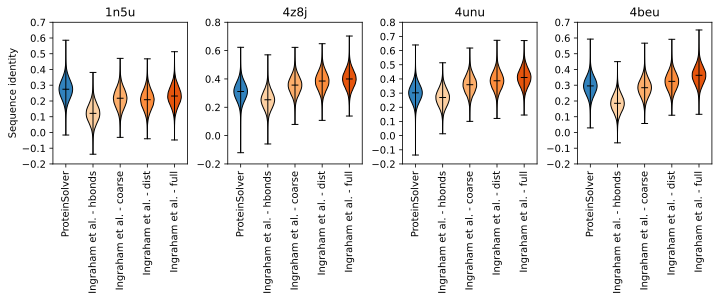

In [53]:
fg, axs = plt.subplots(1, 4, figsize=(10, 4.2))

create_plot(feature="seq_identity", combined_dfs=combined_dfs, axs=axs)
axs[0].set_ylabel("Sequence identity")

fg.subplots_adjust(left=0.072, bottom=0.46, top=0.93, right=0.99, wspace=0.3)
fg.savefig(NOTEBOOK_DIR.joinpath(f"sequence-identities.svg"))
fg.savefig(NOTEBOOK_DIR.joinpath(f"sequence-identities.pdf"))
fg.savefig(NOTEBOOK_DIR.joinpath(f"sequence-identities.png"), dpi=300)

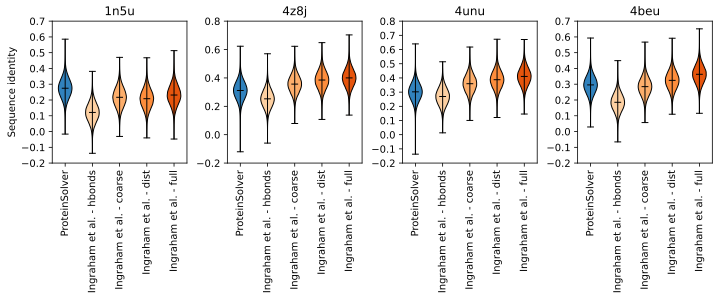

In [54]:
SVG(NOTEBOOK_DIR.joinpath(f"sequence-identities.svg"))

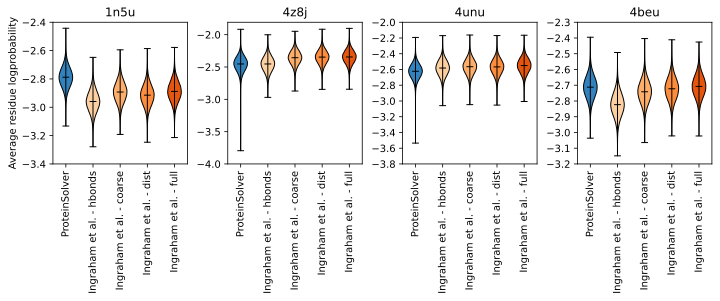

In [55]:
fg, axs = plt.subplots(1, 4, figsize=(10, 4.2))

create_plot(feature=f"avg_logprob_{RL}", combined_dfs=combined_dfs, axs=axs)
axs[0].set_ylabel("Average residue logprobability")

fg.subplots_adjust(left=0.072, bottom=0.46, top=0.93, right=0.99, wspace=0.3)
fg.savefig(NOTEBOOK_DIR.joinpath(f"residue-probabilities-rl{RL}.svg"))
fg.savefig(NOTEBOOK_DIR.joinpath(f"residue-probabilities-rl{RL}.pdf"))
fg.savefig(NOTEBOOK_DIR.joinpath(f"residue-probabilities-rl{RL}.png"), dpi=300)

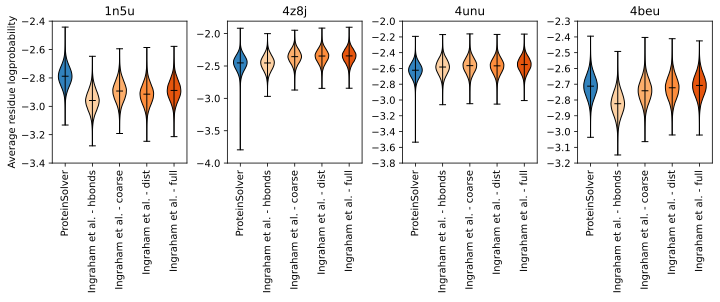

In [56]:
SVG(NOTEBOOK_DIR.joinpath(f"residue-probabilities-rl{RL}.svg"))